In [ ]:
## Control Downloading fresh data
DOWNLOAD_DATA = False

# OBTAIN

### DATA SOURCES:

* **All Donald Trump tweets from 12/01/2016 (pre-inaugaration day) ~~to end of 08/23/2018~~**
    *          ~~Extracted from http://www.trumptwitterarchive.com/~~
    - Trump Twitter Archive 2.0 (now with API endpoint)
    - https://www.thetrumparchive.com/

* **Minute-resolution data for the S&P500 covering the same time period.**
    *         IVE S&P500 Index from - http://www.kibot.com/free_historical_data.aspx
    - (***Aggregate 1 min bid-ask data link***)
        - http://api.kibot.com/?action=history&symbol=IVE&interval=tickbidask1&bp=1&user=guest
    
    
* NOTE: Both sources required manual extraction and both 1-min historical stock data and batch-historical-tweet data are difficult to obtain without paying \\$150-\\$2000 monthly developer memberships. 

In [ ]:
import os,sys,glob,time
sys.path.append('py_files/')

## IMPORT CUSTOM CAPSTONE FUNCTIONS
import functions_combined_BEST as ji
import functions_io as io

## Import data downloading packages
import datetime as dt
import requests
import pandas as pd
import json

In [ ]:
# !pip install -U fsds
from fsds.imports import *

In [ ]:
def download_stock_data(fpath='data/ive_minute_tick_bidask_API.csv',
                       verbose=True,append_date=True):
    """Downloads up-to-date IVE S&P 500 1-min aggregate data from 
    http://www.kibot.com/free_historical_data.aspx
    
    Args:
        fpath (str): csv filepath to save (Default='data/ive_minute_tick_bidask_API.csv')
        verbose (bool): Display file info (Default=True)
        
    Returns:
        stock_df: DataFrame with correct headers and datetime index"""
    agg_url = 'http://api.kibot.com/?action=history&symbol=IVE&interval=tickbidask1&bp=1&user=guest'
    response = requests.get(agg_url,
                            allow_redirects=True)

    ## Save output to csv file
    with open(fpath,'wb') as file:
        file.write(response.content)
        
        
    ## Load in Stock Data Frame with headers (then save)
    headers = ['Date','Time','BidOpen','BidHigh','BidLow','BidClose','AskOpen','AskHigh','AskLow','AskClose']
    stock_df = pd.read_csv(fpath,names=headers)

# 
    ## Make Combined Date Time column and Drop Origs
    stock_df['datetime'] = pd.to_datetime(stock_df['Date'].astype(str)+' '+stock_df['Time'].astype(str))
    
    if append_date:
        suffix = dt.date.today().strftime('%m-%d-%y')
        fpath = f"{fpath.split('.csv')[0]}_{suffix}.csv"
        
    print(f'Saving as {fpath}')
    stock_df.to_csv(fpath,index=False)
        
    if verbose:
        print('[i] Stock data successfully downloaded and saved as:')
        print(' - ',fpath)
        
    return pd.read_csv(fpath,parse_dates=['datetime'],index_col='datetime')

In [ ]:
def download_trump_tweets(fpath='data/trump_tweets.csv',append_date=True,
                          verbose=True,return_data=True):
    """Downloads the most recent data from the trumptwittearchive v2.
    https://drive.google.com/uc?export=download&id=1JZnhB0Nq_2RKtDb-IOnd0XxnD5c7x-nQ
    
    Args:
        fpath (str): filepath for data that ends with .csv
        append_date (bool): Whether to save today's date as part of filename(Default=True)
        verbose (bool): Whether to print the file name (Default=True)
        return_data (bool): Whether to return the data as a df (Default=True)"""
#     url = "https://www.thetrumparchive.com/latest-tweets"
    url="https://drive.google.com/uc?export=download&id=1JZnhB0Nq_2RKtDb-IOnd0XxnD5c7x-nQ"
    response = requests.get(url)
    
    if append_date:
        suffix = "_"+dt.date.today().strftime('%m-%d-%y')
        filepath = f"{fpath.split('.')[0]}{suffix}.{fpath.split('.')[-1]}"
    else:
        filepath=fpath
        
        
    ## Save output to csv file
    with open(filepath,'wb') as file:
        file.write(response.content)  
        
#     with open(filepath,'w') as f:
# #         f.write(response.content)
#         f.write(json.dumps(response.json()))
    
#     if fpath.endswith('.csv'):
#         tweets = pd.read_json(filepath)
#         tweets.to_csv(filepath)
#     else: 
#         tweets = pd.read_json(filepath)
        
    if verbose:
        print('[i] Tweet data successfully downloaded and saved as:')
        print('- ',filepath)
        
    if return_data:

        return pd.read_csv(filepath,index_col=0,parse_dates=['date'])
#tweets#,parse_dates=['created_at'])

In [ ]:
## DOWNLOAD THE DATA IF REQUESTED
if DOWNLOAD_DATA:
    print('[i] Downoading data sets...')
    stock_df = download_stock_data()
    tweets = download_trump_tweets()
    
else: 
    print('[i] Loading most recent data sets...')
    ## Get list of current csvs
    files_glob = glob.glob('data/*.csv')
    stock_files = list(filter(lambda x: 'ive_minute' in x, files_glob))
    tweet_files = list(filter(lambda x: 'tweet' in x, files_glob))


    ## make dictionaries of file date modifieds
    TWEET_FILES = {}
    for file in tweet_files:
        TWEET_FILES[file] = pd.to_datetime(time.ctime(os.path.getmtime(file)))

    STOCK_FILES = {}
    for file in stock_files:
        STOCK_FILES[file] = pd.to_datetime(time.ctime(os.path.getmtime(file)))

        
    ## Get most recent files
    recent_stocks = pd.Series(STOCK_FILES).idxmax()
    recent_tweets = pd.Series(TWEET_FILES).idxmax()
    
    ## Load in the csvs 
    tweets = pd.read_csv(recent_tweets,parse_dates=['date'],index_col='date')
    stock_df = pd.read_csv(recent_stocks,parse_dates=['datetime'],index_col='datetime')
    
    ## Sort timeseries
    tweets.sort_index(inplace=True)
    stock_df.sort_index(inplace=True)
## Display Preview of DFs
display(stock_df.head(),tweets.head())

In [ ]:
stock_df.shape, tweets.shape

# Creating the Target

In [8]:
stock_df = stock_df[['BidClose']].sort_index()#.reset_index()#.asfreq('T')
stock_df

,BidClose
datetime,
2009-09-28 09:30:00,39.06
2009-09-28 09:31:00,39.09
2009-09-28 09:32:00,39.15
2009-09-28 09:33:00,39.14
2009-09-28 09:34:00,39.12
...,...
2020-10-23 15:56:00,116.83
2020-10-23 15:57:00,116.86
2020-10-23 15:58:00,116.82


## Stock Preprocessing

In [9]:
# ## Remove rare 0-values
stock_df = stock_df[~(stock_df==0).any(axis=1)]
stock_df.shape

(913039, 1)

<AxesSubplot:xlabel='datetime'>

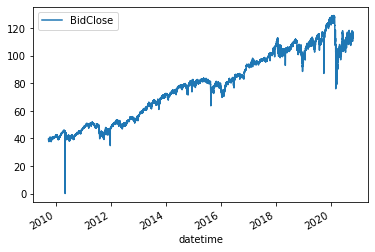

In [10]:
stock_df.plot()

In [11]:
## Now, convert stock_df to minute frequency
stock_df = stock_df.asfreq('T')
stock_df.index

DatetimeIndex(['2009-09-28 09:30:00', '2009-09-28 09:31:00',
               '2009-09-28 09:32:00', '2009-09-28 09:33:00',
               '2009-09-28 09:34:00', '2009-09-28 09:35:00',
               '2009-09-28 09:36:00', '2009-09-28 09:37:00',
               '2009-09-28 09:38:00', '2009-09-28 09:39:00',
               ...
               '2020-10-23 15:51:00', '2020-10-23 15:52:00',
               '2020-10-23 15:53:00', '2020-10-23 15:54:00',
               '2020-10-23 15:55:00', '2020-10-23 15:56:00',
               '2020-10-23 15:57:00', '2020-10-23 15:58:00',
               '2020-10-23 15:59:00', '2020-10-23 16:00:00'],
              dtype='datetime64[ns]', name='datetime', length=5822311, freq='T')

In [12]:
stock_df.isna().sum()

BidClose    4909272
dtype: int64

In [13]:
# (stock_df==0).sum()

## Tweet Processing

In [14]:
display(tweets.head(),tweets.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54442 entries, 2009-05-04 18:54:25 to 2020-10-24 20:13:08
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         54442 non-null  int64 
 1   text       54442 non-null  object
 2   isRetweet  54442 non-null  object
 3   isDeleted  54442 non-null  object
 4   device     54442 non-null  object
 5   favorites  54442 non-null  int64 
 6   retweets   54442 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 3.3+ MB


,id,text,isRetweet,isDeleted,device,favorites,retweets
date,,,,,,,
2009-05-04 18:54:25,1698308935,Be sure to tune in and watch Donald Trump on L...,f,f,Twitter Web Client,939,519
2009-05-05 01:00:10,1701461182,Donald Trump will be appearing on The View tom...,f,f,Twitter Web Client,259,34
2009-05-08 13:38:08,1737479987,Donald Trump reads Top Ten Financial Tips on L...,f,f,Twitter Web Client,37,15
2009-05-08 20:40:15,1741160716,New Blog Post: Celebrity Apprentice Finale and...,f,f,Twitter Web Client,29,11
2009-05-12 14:07:28,1773561338,"""""""My persona will never be that of a wallflow...",f,f,Twitter Web Client,1877,1321


None

### Finding the Matching Tweets/Stock Data

In [15]:
tweets.reset_index()['date'].dt.ceil('T')

0       2009-05-04 18:55:00
1       2009-05-05 01:01:00
2       2009-05-08 13:39:00
3       2009-05-08 20:41:00
4       2009-05-12 14:08:00
                ...        
54437   2020-10-24 18:55:00
54438   2020-10-24 18:56:00
54439   2020-10-24 18:57:00
54440   2020-10-24 20:12:00
54441   2020-10-24 20:14:00
Name: date, Length: 54442, dtype: datetime64[ns]

In [16]:
import math


In [17]:
tweets[tweets['text'].str.contains('Sleepy Joe')]#.tail(20)]

,id,text,isRetweet,isDeleted,device,favorites,retweets
date,,,,,,,
2019-04-17 01:24:39,1118324360383746050,I believe it will be Crazy Bernie Sanders vs. ...,f,f,Twitter for iPhone,124566,24228
2019-04-25 12:22:18,1121388967444799488,Welcome to the race Sleepy Joe. I only hope yo...,f,f,Twitter for iPhone,144614,27915
2019-04-28 03:10:25,1122337243744497664,"....for the more traditional, but not very bri...",f,f,Twitter for iPhone,85659,16740
2019-04-29 14:42:12,1122873726276599809,The Media (Fake News) is pushing Sleepy Joe ha...,f,f,Twitter for iPhone,100310,22178
2019-04-29 14:51:03,1122875949933051904,Sleepy Joe Biden is having his first rally in ...,f,f,Twitter for iPhone,67529,14946
...,...,...,...,...,...,...,...
2020-10-16 10:44:59,1317053924096999426,Sleepy Joe Biden had a very bad showing last n...,f,f,Twitter for iPhone,120171,30734
2020-10-18 16:02:48,1317858680461668352,"Very proud of the @nypost, my former “hometown...",f,f,Twitter for iPhone,171788,46782
2020-10-20 22:09:42,1318675789248946176,...Everyone should compare this terrible Elect...,f,f,Twitter for iPhone,147574,28916


In [18]:
## Fixing Tweet Timestamps
## Obama is campaining for us. Tweet
test_ts = '2020-10-22 15:26'
tweets_df_ts = pd.to_datetime(test_ts)
twitter_ts = pd.to_datetime('11:26 AM  Oct 22, 2020')
twitter_ts,tweets_df_ts

(Timestamp('2020-10-22 11:26:00'), Timestamp('2020-10-22 15:26:00'))

In [19]:
tweets.loc[test_ts]

,id,text,isRetweet,isDeleted,device,favorites,retweets
date,,,,,,,
2020-10-22 15:26:26,1319299079264940039,Obama is campaigning for us. Every time he spe...,f,f,Twitter for iPhone,206025,36232


In [20]:
tweets[tweets['text'].str.contains('covfefe')]

,id,text,isRetweet,isDeleted,device,favorites,retweets
date,,,,,,,
2017-05-31 04:06:25,869766994899468288,Despite the constant negative press covfefe,f,t,Twitter for iPhone,162788,127507
2017-05-31 10:09:22,869858333477523458,"""Who can figure out the true meaning of """"covf...",f,f,Twitter for iPhone,177291,68046


In [21]:
tweets[tweets['text'].str.contains('covfefe')].index[0]


Timestamp('2017-05-31 04:06:25')

In [22]:
## Second test_ts to verify time delay
test_ts2 = "2017-05-31 04:06"
tweets_df_ts2 = pd.to_datetime(test_ts2)#tweets[tweets['text'].str.contains('covfefe')].index[0]

twitter_ts2 = pd.to_datetime('6:09 AM  May 31, 2017')
twitter_ts2,tweets_df_ts2

(Timestamp('2017-05-31 06:09:00'), Timestamp('2017-05-31 04:06:00'))

In [23]:
# tweets_df_ts.tz

In [24]:
## save tdelta to use to fix tweet timestamps
tdelta = pd.to_timedelta(tweets_df_ts - twitter_ts,unit='min')
tdelta

Timedelta('0 days 04:00:00')

In [25]:
## save tdelta to use to fix tweet timestamps
tdelta2 = pd.to_timedelta(tweets_df_ts2 - twitter_ts2,unit='min')
tdelta2

Timedelta('-1 days +21:57:00')

In [26]:
## Making Corrected Date
tweets['date-corrected'] = tweets.index - tdelta
tweets

,id,text,isRetweet,isDeleted,device,favorites,retweets,date-corrected
date,,,,,,,,
2009-05-04 18:54:25,1698308935,Be sure to tune in and watch Donald Trump on L...,f,f,Twitter Web Client,939,519,2009-05-04 14:54:25
2009-05-05 01:00:10,1701461182,Donald Trump will be appearing on The View tom...,f,f,Twitter Web Client,259,34,2009-05-04 21:00:10
2009-05-08 13:38:08,1737479987,Donald Trump reads Top Ten Financial Tips on L...,f,f,Twitter Web Client,37,15,2009-05-08 09:38:08
2009-05-08 20:40:15,1741160716,New Blog Post: Celebrity Apprentice Finale and...,f,f,Twitter Web Client,29,11,2009-05-08 16:40:15
2009-05-12 14:07:28,1773561338,"""""""My persona will never be that of a wallflow...",f,f,Twitter Web Client,1877,1321,2009-05-12 10:07:28
...,...,...,...,...,...,...,...,...
2020-10-24 18:54:47,1320076289034850306,Joe Biden = Biggest Tax Increase In History an...,f,f,Twitter for iPhone,57012,11744,2020-10-24 14:54:47
2020-10-24 18:55:38,1320076502839459842,MAKE AMERICA GREAT AGAIN!,f,f,Twitter for iPhone,152417,24873,2020-10-24 14:55:38
2020-10-24 18:56:09,1320076630065373184,AMERICA FIRST!,f,f,Twitter for iPhone,89661,14937,2020-10-24 14:56:09


In [27]:
## Make new date-corrected index
tweets = tweets.reset_index(drop=False).set_index('date-corrected')

In [28]:
## Getting first, alst stock_df
first_stock_ts = stock_df.index[0]
last_stock_ts = stock_df.index[-1]
first_stock_ts,last_stock_ts

(Timestamp('2009-09-28 09:30:00', freq='T'),
 Timestamp('2020-10-23 16:00:00', freq='T'))

In [29]:
first_tweet_ts = tweets.index[0]
last_tweet_ts = tweets.index[-1]
first_tweet_ts,last_tweet_ts

(Timestamp('2009-05-04 14:54:25'), Timestamp('2020-10-24 16:13:08'))

In [30]:
## MAKING DF TIME PERIODS MATCH
stock_df = stock_df.loc[first_tweet_ts:]
stock_df

,BidClose
datetime,
2009-09-28 09:30:00,39.06
2009-09-28 09:31:00,39.09
2009-09-28 09:32:00,39.15
2009-09-28 09:33:00,39.14
2009-09-28 09:34:00,39.12
...,...
2020-10-23 15:56:00,116.83
2020-10-23 15:57:00,116.86
2020-10-23 15:58:00,116.82


In [59]:
## Cutting both dfs to match the timespan of the other
tweets = tweets.loc[first_stock_ts:last_stock_ts-pd.to_timedelta('60T')]
tweets

,date,id,text,isRetweet,isDeleted,device,favorites,retweets,stock_time,tweet_minute,tweet_minute_price
date-corrected,,,,,,,,,,,
2009-09-29 11:28:23,2009-09-29 15:28:23,4472353826,"""""""A lot of people have imagination, but can't...",f,f,Twitter Web Client,138,74,2009-09-29 12:29:00,2009-09-29 11:29:00,39.73
2009-10-05 10:37:38,2009-10-05 14:37:38,4629116949,- Read what Donald Trump has to say about daug...,f,f,Twitter Web Client,14,10,2009-10-05 11:38:00,2009-10-05 10:38:00,38.56
2009-10-14 10:13:17,2009-10-14 14:13:17,4862580190,Watch video of Ivanka Trump sharing business a...,f,f,Twitter Web Client,19,12,2009-10-14 11:14:00,2009-10-14 10:14:00,40.46
2009-10-22 09:57:04,2009-10-22 13:57:04,5069623974,"Hear Donald Trump discuss big gov spending, ba...",f,f,Twitter Web Client,28,7,2009-10-22 10:58:00,2009-10-22 09:58:00,39.81
2009-10-27 11:31:48,2009-10-27 15:31:48,5203117820,"""--From Donald Trump: """"Ivanka and Jared’s wed...",f,f,Twitter Web Client,14,11,2009-10-27 12:32:00,2009-10-27 11:32:00,39.26
...,...,...,...,...,...,...,...,...,...,...,...
2020-10-23 12:55:29,2020-10-23 16:55:29,1319683876046934016,HUGE win today for the United States and for p...,f,f,Twitter for iPhone,211044,50959,2020-10-23 13:56:00,2020-10-23 12:56:00,116.30
2020-10-23 13:09:21,2020-10-23 17:09:21,1319687368014704642,Today is the LAST DAY to register to VOTE in-p...,f,f,Twitter for iPhone,52213,10785,2020-10-23 14:10:00,2020-10-23 13:10:00,116.40
2020-10-23 13:54:01,2020-10-23 17:54:01,1319698607851868160,RT @IvankaTrump: Yesterday @realDonaldTrump gr...,t,f,Twitter for iPhone,0,46485,2020-10-23 14:55:00,2020-10-23 13:55:00,116.59


In [47]:
## Get start_ts (tweet_minute) and end_ts (tweet_minute+target_offset)
target_offset = pd.to_timedelta('60T')

## Fill in new stock_time column
tweets['stock_time'] = tweets.index+ target_offset 
tweets['stock_time'] = tweets['stock_time'].dt.ceil('T')

In [48]:
tweets.tail(40)

,date,id,text,isRetweet,isDeleted,device,favorites,retweets,stock_time,tweet_minute
date-corrected,,,,,,,,,,
2020-10-22 23:41:20,2020-10-23 03:41:20,1319484022439829504,RT @BuckSexton: Trump won the debate. This one...,t,f,Twitter for iPhone,0,11926,2020-10-23 00:42:00,2020-10-22 23:42:00
2020-10-22 23:42:05,2020-10-23 03:42:05,1319484210101379072,RT @EliseStefanik: President @realDonaldTrump ...,t,f,Twitter for iPhone,0,9912,2020-10-23 00:43:00,2020-10-22 23:43:00
2020-10-22 23:46:25,2020-10-23 03:46:25,1319485303363571714,RT @RandPaul: I don’t know why @JoeBiden think...,t,f,Twitter for iPhone,0,20645,2020-10-23 00:47:00,2020-10-22 23:47:00
2020-10-22 23:57:21,2020-10-23 03:57:21,1319488054608818178,"RT @megynkelly: Trump won this debate, handily...",t,f,Twitter for iPhone,0,34396,2020-10-23 00:58:00,2020-10-22 23:58:00
2020-10-22 23:57:45,2020-10-23 03:57:45,1319488152180961285,"RT @RealRLimbaugh: Winning, winning, winning! ...",t,f,Twitter for iPhone,0,18966,2020-10-23 00:58:00,2020-10-22 23:58:00
2020-10-22 23:58:38,2020-10-23 03:58:38,1319488376202878977,RT @marklevinshow: President Trump was outstan...,t,f,Twitter for iPhone,0,21317,2020-10-23 00:59:00,2020-10-22 23:59:00
2020-10-23 00:09:59,2020-10-23 04:09:59,1319491234042269696,"As per your request, Joe... https://t.co/78mzc...",f,f,Twitter for iPhone,238061,74040,2020-10-23 01:10:00,2020-10-23 00:10:00
2020-10-23 00:15:01,2020-10-23 04:15:01,1319492499639988226,RT @EricTrump: 🇺🇸🇺🇸🇺🇸 https://t.co/C6HRtPW4Mz,t,f,Twitter for iPhone,0,26131,2020-10-23 01:16:00,2020-10-23 00:16:00
2020-10-23 00:21:46,2020-10-23 04:21:46,1319494198039441409,RT @seanmdav: Biden's message tonight at the d...,t,f,Twitter for iPhone,0,20757,2020-10-23 01:22:00,2020-10-23 00:22:00


In [49]:
tweets['tweet_minute'] = tweets.index.ceil('T')
tweets

,date,id,text,isRetweet,isDeleted,device,favorites,retweets,stock_time,tweet_minute
date-corrected,,,,,,,,,,
2009-09-29 11:28:23,2009-09-29 15:28:23,4472353826,"""""""A lot of people have imagination, but can't...",f,f,Twitter Web Client,138,74,2009-09-29 12:29:00,2009-09-29 11:29:00
2009-10-05 10:37:38,2009-10-05 14:37:38,4629116949,- Read what Donald Trump has to say about daug...,f,f,Twitter Web Client,14,10,2009-10-05 11:38:00,2009-10-05 10:38:00
2009-10-14 10:13:17,2009-10-14 14:13:17,4862580190,Watch video of Ivanka Trump sharing business a...,f,f,Twitter Web Client,19,12,2009-10-14 11:14:00,2009-10-14 10:14:00
2009-10-22 09:57:04,2009-10-22 13:57:04,5069623974,"Hear Donald Trump discuss big gov spending, ba...",f,f,Twitter Web Client,28,7,2009-10-22 10:58:00,2009-10-22 09:58:00
2009-10-27 11:31:48,2009-10-27 15:31:48,5203117820,"""--From Donald Trump: """"Ivanka and Jared’s wed...",f,f,Twitter Web Client,14,11,2009-10-27 12:32:00,2009-10-27 11:32:00
...,...,...,...,...,...,...,...,...,...,...
2020-10-23 15:30:21,2020-10-23 19:30:21,1319722848898879488,https://t.co/S4Hl0i6Qdp,f,f,Twitter for iPhone,49399,14124,2020-10-23 16:31:00,2020-10-23 15:31:00
2020-10-23 15:35:00,2020-10-23 19:35:00,1319724018778296321,On the 37th anniversary of the horrendous atta...,f,f,Twitter for iPhone,149414,29147,2020-10-23 16:35:00,2020-10-23 15:35:00
2020-10-23 15:36:03,2020-10-23 19:36:03,1319724283321413632,https://t.co/CGlqRmhTV4,f,f,Twitter for iPhone,73851,17644,2020-10-23 16:37:00,2020-10-23 15:37:00


In [50]:
# ## get single test ts
# i = '2020-10-22 15:50:56'
# ts = tweets.loc[i,'tweet_minute']#'tweet_minutes']
# ts

In [51]:
# tweet_price = stock_df.loc[ts]
# tweet_price

In [52]:
# ts = tweets.loc[i,'stock_time']
# ts

In [53]:
# ## Get stock_df value at stock_time
# stock_time_price = stock_df.loc[ts]
# stock_time_price

In [54]:
# stock_df.index

In [55]:
# stock_df.loc['2009-05-04']

In [56]:
# stock_df.loc['2009-05-04 14:55:00']

In [57]:
## Retrieve Tweet Prices
tweets['tweet_minute_price'] = tweets['tweet_minute'].apply(lambda x: stock_df.loc[x])

In [60]:
## Retrieve Target-Timedelta Prices
tweets['stock_time_price'] = tweets['stock_time'].apply(lambda x: stock_df.loc[x])

# BOOKMARK

In [62]:
tweets.isna().sum()

date                      0
id                        0
text                      0
isRetweet                 0
isDeleted                 0
device                    0
favorites                 0
retweets                  0
stock_time                0
tweet_minute              0
tweet_minute_price    41566
stock_time_price      41784
dtype: int64

In [63]:
## Save csv
tweets.to_csv('data/trump_tweets_plus_stock_prices.csv')

In [ ]:
# tweets['stock_time'].tail(30)

In [ ]:
## Get stock value at tweet_minute


In [ ]:
# ## Train Test Split
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train,y_test = train_test_split(X,y,random_state=42)

In [ ]:
# df.index